### Xception - Stanford Dogs dataset classification

If you like this script, consider adopting a dog, and never abandon yours

![Never abandon a dog](http://www.the-teen-spirit.dk/films/vanwilder/image.jpg)



I will be performing following steps :
1. Importing the data 
2. Data Argumentation And Visualization 
3. Importing the Xception ( Transfer learning ) 
4. Fully Connected layer 
5. Model Training 
6. Accuracy And Loss Visualization 




# **ABOUT THE DATASET **

The Stanford Dogs dataset contains images of 120 breeds of dogs from around the world. This dataset has been built using images and annotation from ImageNet for the task of fine-grained image categorization. It was originally collected for fine-grain image categorization, a challenging problem as certain dog breeds have near identical features or differ in colour and age.


## 1. IMPORTING THE LIBRARIES AND DATA 

In [1]:
!pip install tf_explain
!pip install split-folders
!conda install -y gdown

     |████████████████████████████████| 41 kB 324 kB/s eta 0:00:011
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
Solving environment: done

## Package Plan ##

  environment location: /opt/conda

  added / updated specs:
    - gdown


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    gdown-3.12.0               |     pyh9f0ad1d_0          12 KB  conda-forge
    openssl-1.1.1g             |       h516909a_1         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.1 MB

The following NEW packages will be INSTALLED:

  gdown              conda-forge/noarch::gdown-3.12.0-pyh9f0ad1d_0

The following packages will be UPDATED:

  openssl        

In [31]:
import os
import pandas as pd
import split_folders
import gdown
import time
import math
import cv2
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.image as image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.applications.xception import Xception, preprocess_input
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tf_explain.core.activations import ExtractActivations

from tensorflow.keras.applications.xception import decode_predictions
%matplotlib inline
from sklearn.metrics import classification_report
from PIL import Image
import matplotlib.image as mpimg
print("Loaded all libraries")

Loaded all libraries


In [3]:
image_path = '../input/stanford-dogs-dataset/images/Images'
num_of_categories = 120
image_size = 299
batch_size = 16

In [4]:
orig_path = image_path
output_path = '/input/dataset/'
split_folders.ratio(orig_path, output=output_path, seed=1337, ratio=(0.8, 0.1, 0.1))

Copying files: 20580 files [00:53, 385.10 files/s]


In [5]:
train_path = '/input/dataset/train'
validation_path = '/input/dataset/val'
test_path = '/input/dataset/test'

In [6]:
# Define a time counter function to test the algorythms performance 
_start_time = time.time()

def process_time_starts():
    global _start_time 
    _start_time = time.time()

def time_elapsed():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('The process took: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))


In [7]:
def preprocessImage(img):
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    return preprocess_input(img)

def image_datagen_load():

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=30, 
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        zoom_range=0.15,
        horizontal_flip=True,
        preprocessing_function = preprocessImage)
    
    test_datagen = ImageDataGenerator(rescale=1./255, preprocessing_function=preprocess_input)
      
    train_datagen = train_datagen.flow_from_directory(train_path,
        target_size=(image_size, image_size), color_mode='rgb', classes=None, interpolation='hamming',
        class_mode='categorical', batch_size=batch_size, shuffle=True)

    val_datagen = test_datagen.flow_from_directory(validation_path,
        target_size=(image_size, image_size), color_mode='rgb', classes=None, interpolation='hamming',
        class_mode='categorical', batch_size= 1, shuffle=False)
    
    test_datagen = test_datagen.flow_from_directory(test_path,
        target_size=(image_size, image_size), color_mode='rgb', classes=None, interpolation='hamming',
        class_mode='categorical', batch_size= 1, shuffle=False)
    
    return train_datagen, val_datagen, test_datagen

In [8]:
# image loading 

train_ds, val_ds, test_ds = image_datagen_load()

Found 16418 images belonging to 120 classes.
Found 2009 images belonging to 120 classes.
Found 2153 images belonging to 120 classes.


## 2. MODEL PREPARATION 

### 2.1 IMPORTING THE Xception CNN

In [9]:


#url = 'https://drive.google.com/uc?id=1aCFGR5c7Ap4JPzryR_RSgRYc7FRYgbyG'

#output = 'xception_weights.h5'

#gdown.download(url, output, quiet=False)

In [10]:
pre_trained_model = tf.keras.applications.xception.Xception(weights='imagenet',include_top=False, pooling='avg')#Summary of Xception Model

pre_trained_model.trainable = True


#pre_trained_model.summary()



83689472/83683744 [==============================] - 1s 0us/step


### 2.2 FULLY CONNECTED LAYER

[2e-05, 1.3010229111699174e-05, 2.799794814975629e-05, 4.2316515384726154e-05, 5.269961228093217e-05, 5.8065563007143795e-05, 5.879311806157915e-05, 5.595898357205517e-05, 5.08036444487631e-05, 4.4435986152969225e-05, 3.771206913827348e-05, 3.1218607475338754e-05, 2.530855380127946e-05, 2.015528123266929e-05, 1.5806874880680855e-05, 1.2232061884443514e-05, 9.355219223545637e-06, 7.080961013103805e-06, 5.310103351475864e-06, 3.9491137307737464e-06, 2.914976255928358e-06, 2.137040058136618e-06, 1.5570250929005795e-06, 1.1280109406241628e-06, 8.129561033792263e-07]


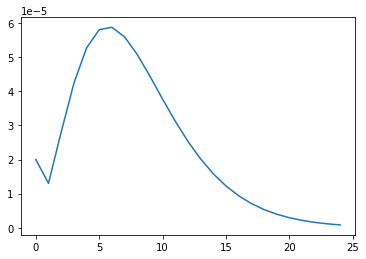

In [11]:
###################
total_epoch = 25
learning_rate_init = 0.00002
###################

def lr_scheduler(epoch):
    epoch += 1
   
    if epoch == 1:
        return learning_rate_init
    
    elif epoch >= 2 and epoch <= 40:
        return (0.2*epoch**3)*math.exp(-0.45*epoch)*learning_rate_init
    
    else:
        return lr_scheduler(40-1)
    

stage = [i for i in range(0,25)]
learning_rate = [lr_scheduler(x) for x in stage]
plt.plot(stage, learning_rate)
print(learning_rate)

In [12]:
flat_dim = 5 * 5 * 2048

my_model = Sequential(pre_trained_model)

#my_model.add(Flatten())
#my_model.add(Dropout(0.1)) # dropout added
my_model.add(Dense(1032, activation='relu',input_dim=flat_dim))
my_model.add(Dropout(0.2))
my_model.add(Dense(256, activation='relu'))
my_model.add(Dropout(0.2))
my_model.add(Dense(120, activation='softmax'))

my_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])


# Callbacks

scheduler = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
early_stop = EarlyStopping(monitor='val_accuracy', patience = 4, mode='max', min_delta=1, verbose=1)

## 3. TRAINING THE MODEL

In [13]:
process_time_starts()

hist = my_model.fit_generator(generator=train_ds, steps_per_epoch=700, validation_data=val_ds, 
           validation_steps=90, epochs=total_epoch, callbacks=[scheduler, early_stop])


                  


Epoch 00001: LearningRateScheduler reducing learning rate to 2e-05.
Epoch 1/25
700/700 [==============================] - 400s 571ms/step - loss: 3.8439 - accuracy: 0.2839 - val_loss: 1.1744 - val_accuracy: 0.7556 - lr: 2.0000e-05

Epoch 00002: LearningRateScheduler reducing learning rate to 1.3010229111699174e-05.
Epoch 2/25
700/700 [==============================] - 400s 572ms/step - loss: 1.8082 - accuracy: 0.6425 - val_loss: 0.7114 - val_accuracy: 0.8778 - lr: 1.3010e-05

Epoch 00003: LearningRateScheduler reducing learning rate to 2.799794814975629e-05.
Epoch 3/25
700/700 [==============================] - 404s 577ms/step - loss: 1.0280 - accuracy: 0.7542 - val_loss: 0.6690 - val_accuracy: 0.8111 - lr: 2.7998e-05

Epoch 00004: LearningRateScheduler reducing learning rate to 4.2316515384726154e-05.
Epoch 4/25
700/700 [==============================] - 410s 586ms/step - loss: 0.7195 - accuracy: 0.8050 - val_loss: 0.4494 - val_accuracy: 0.8556 - lr: 4.2317e-05

Epoch 00005: Learning

In [14]:
time_elapsed()

The process took: 0hour:33min:58sec


### 4. LOSS AND ACCURACY VISUALIZATION 

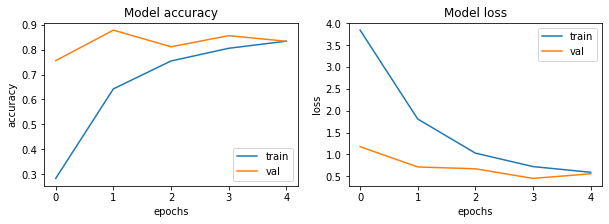

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(10, 3))
ax = ax.ravel()

for i, met in enumerate(['accuracy', 'loss']):
    ax[i].plot(hist.history[met])
    ax[i].plot(hist.history['val_' + met])
    ax[i].set_title('Model {}'.format(met))
    ax[i].set_xlabel('epochs')
    ax[i].set_ylabel(met)
    ax[i].legend(['train', 'val'])

### 5. Save model and parameters

In [16]:

pre_trained_model.save_weights('dog_breed_xcept_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk


### 6. Test model accuracy

In [17]:
test_loss, test_accuracy = my_model.evaluate_generator(generator=test_ds,steps=int(100))

print("Test results \n Loss:",test_loss,'\n Accuracy',test_accuracy)

[0.5286172032356262, 0.8799999952316284]

In [27]:

#report = classification_report(test_ds.classes, pred, target_names=class_to_id)
#print(report)

## 7. Predict new images

In [36]:
breed_list = os.listdir("../input/stanford-dogs-dataset/images/Images/")

num_classes = len(breed_list)
print("{} breeds".format(num_classes))

120 breeds


In [ ]:
label_maps = {}
label_maps_rev = {}
for i, v in enumerate(breed_list):
    label_maps.update({v: i})
    label_maps_rev.update({i : v})

In [34]:
def download_and_predict(url, filename):
    # download and save
    os.system("curl -s {} -o {}".format(url, filename))
    img = Image.open(filename)
    img = img.convert('RGB')
    img = img.resize((224, 224))
    img.save(filename)
    # show image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')
    # predict
    img = image.imread(filename)
    img = preprocess_input(img)
    probs = my_model.predict(np.expand_dims(img, axis=0))
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", label_maps_rev[idx].split("-")[-1])

NameError: name 'label_maps_rev' is not defined

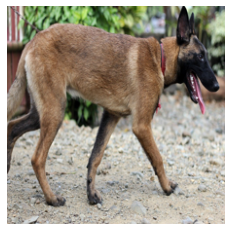

In [35]:
download_and_predict("https://cdn.pixabay.com/photo/2018/08/12/02/52/belgian-mallinois-3599991_1280.jpg",
                     "test_1.jpg")

